In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [40]:
# Load the provided CSV file to inspect the data
file_path = 'pulsedata_081024.csv'
pulse_data = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
pulse_data.head()

,Unnamed: 0,Time,Raw Data (mV),Averaged data (20 samples)
0,NaN,-0.700707,42.12775,48.068788
1,NaN,-0.700040,44.96902,48.571886
2,NaN,-0.699373,47.75842,48.784143
3,NaN,-0.698707,44.02295,48.818781
4,NaN,-0.698040,45.97308,49.206824


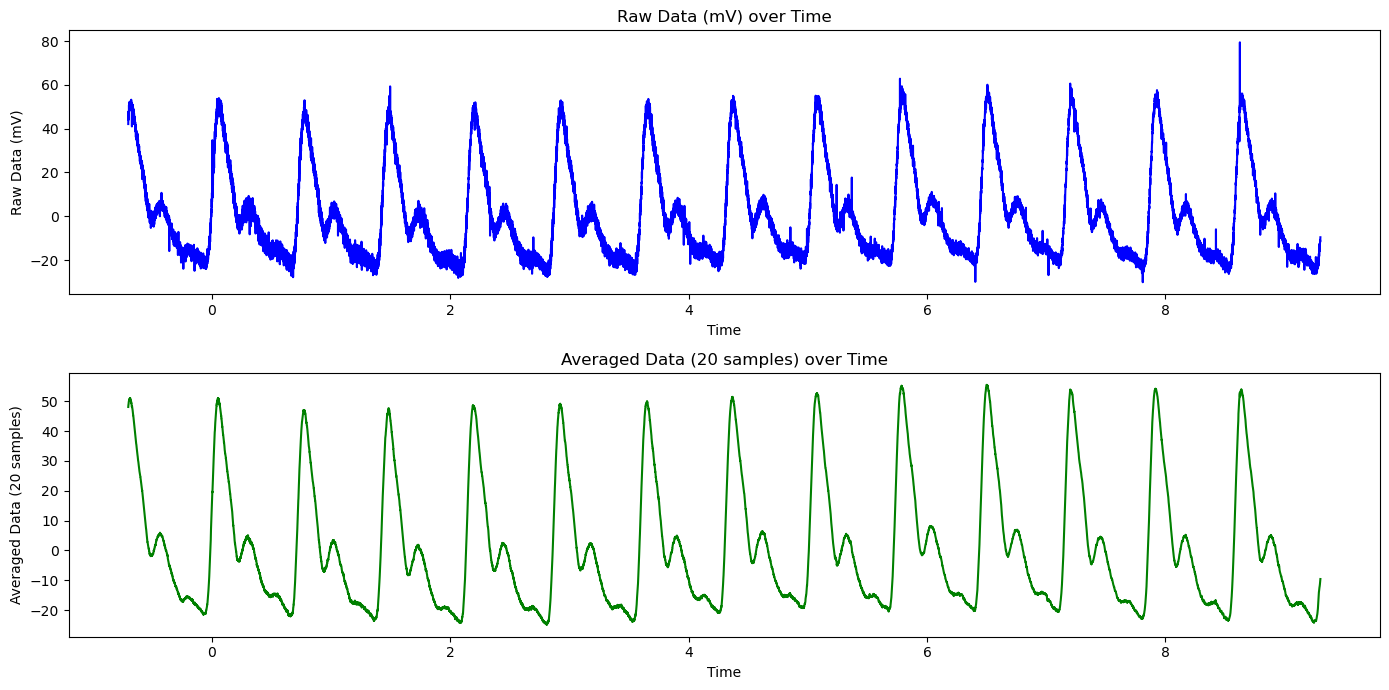

In [41]:
# Drop the unnecessary column
data_cleaned = pulse_data.drop(columns=['Unnamed: 0'])

# Plot Raw Data (mV) and Averaged Data (20 samples) over Time
plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
plt.plot(data_cleaned['Time'], data_cleaned['Raw Data (mV)'], color='blue')
plt.title('Raw Data (mV) over Time')
plt.xlabel('Time')
plt.ylabel('Raw Data (mV)')

plt.subplot(2, 1, 2)
plt.plot(data_cleaned['Time'], data_cleaned['Averaged data (20 samples)'], color='green')
plt.title('Averaged Data (20 samples) over Time')
plt.xlabel('Time')
plt.ylabel('Averaged Data (20 samples)')

plt.tight_layout()
plt.show()

In [42]:
# Define a bandpass filter to remove noise (as described in the paper)
def bandpass_filter(data, lowcut=0.1, highcut=20.0, fs=125, order=2):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

# Apply bandpass filter to the 'Raw Data (mV)' column
pulse_data['Filtered Data'] = bandpass_filter(pulse_data['Raw Data (mV)'])

# Normalize the filtered data
pulse_data['Normalized Data'] = (pulse_data['Filtered Data'] - np.mean(pulse_data['Filtered Data'])) / np.std(pulse_data['Filtered Data'])

# Display the first few rows of the processed data to verify
pulse_data[['Time', 'Raw Data (mV)', 'Filtered Data', 'Normalized Data']].head()

,Time,Raw Data (mV),Filtered Data,Normalized Data
0,-0.700707,42.12775,11.795428,0.706426
1,-0.700040,44.96902,14.037883,0.841062
2,-0.699373,47.75842,15.351637,0.919939
3,-0.698707,44.02295,15.720584,0.942090
4,-0.698040,45.97308,15.862082,0.950585


In [43]:
# Prepare the data
X = data_cleaned[['Time', 'Averaged data (20 samples)']].values
y = data_cleaned['Raw Data (mV)'].values

# Reshape the data for CNN (add a channel dimension)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Split the data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=2, padding='same', activation='relu', input_shape=(X_train.shape[1], 1)),
    tf.keras.layers.Conv1D(filters=32, kernel_size=2, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(1)  # Output layer
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mse, r2

Epoch 1/50
375/375 [==============================] - 1s 949us/step - loss: 24.6090 - val_loss: 8.7514
Epoch 2/50
375/375 [==============================] - 0s 791us/step - loss: 8.5082 - val_loss: 8.7286
Epoch 3/50
375/375 [==============================] - 0s 820us/step - loss: 8.5318 - val_loss: 8.4006
Epoch 4/50
375/375 [==============================] - 0s 797us/step - loss: 8.5656 - val_loss: 9.1810
Epoch 5/50
375/375 [==============================] - 0s 775us/step - loss: 8.6212 - val_loss: 8.3821
Epoch 6/50
375/375 [==============================] - 0s 781us/step - loss: 8.5982 - val_loss: 8.4795
Epoch 7/50
375/375 [==============================] - 0s 778us/step - loss: 8.7294 - val_loss: 8.4493
Epoch 8/50
375/375 [==============================] - 0s 799us/step - loss: 8.6084 - val_loss: 8.4892
Epoch 9/50
375/375 [==============================] - 0s 782us/step - loss: 8.5464 - val_loss: 8.5548
Epoch 10/50
375/375 [==============================] - 0s 780us/step - loss: 8.66

(8.492912819904689, 0.9813316293148566)

These results indicate that the model has a good fit, with an R² score close to 1, suggesting that the model can explain approximately 98% of the variance in the Raw Data (mV) using the features extracted.

#### Here is a detailed explanation of the specific layers used in the CNN and the reasoning behind them, combined with the previously discussed principles.

1. First Convolutional Layer (Conv1D)

	•	Layer Configuration: The first convolutional layer uses 32 filters, each with a kernel size of 2. The layer is configured with “same” padding, meaning the output data maintains the same length as the input.
	•	Purpose: This layer’s primary function is to capture local features within the pulse waveform data. Given that pulse waveforms exhibit strong temporal correlations, this convolutional layer is designed to detect subtle changes between adjacent data points, which may be indicative of variations in blood pressure.

2. Second Convolutional Layer (Conv1D)

	•	Layer Configuration: The second convolutional layer also uses 32 filters, with the same kernel size and padding configuration as the first layer.
	•	Purpose: This layer further extracts higher-level features from the pulse waveform, which may be more complex and strongly correlated with blood pressure. Stacking multiple convolutional layers allows the model to learn multi-level structures within the data, enhancing its predictive capabilities.

3. Flatten Layer

	•	Layer Configuration: After the convolutional operations, the data is passed to a flattening layer, which converts the multi-dimensional data into a one-dimensional vector.
	•	Purpose: This step is crucial for transitioning from local feature extraction to global feature processing. By flattening the data, the model can integrate all extracted features and prepare them for further processing by the fully connected layers.

4. Dense Layer (Fully Connected Layer)

	•	Layer Configuration: The flattened data is fed into a dense layer with 50 neurons.
	•	Purpose: This layer integrates the extracted features and applies a nonlinear transformation (using the ReLU activation function) to capture the complex relationships between the pulse waveform data and blood pressure. This step is key to enabling the model to learn intricate patterns that relate to the target output.

5. Output Layer

	•	Layer Configuration: The final output layer is a single-neuron fully connected layer that directly outputs a scalar value, representing the predicted blood pressure.
	•	Purpose: This layer is responsible for converting all processed and integrated features into a concrete prediction. Since this is a regression task, no activation function is used in the output layer, allowing the model to produce continuous values rather than discrete labels.

Reasoning Behind the Specific Layer Usage

1. Local Perception and Weight Sharing: The convolutional layers automatically learn and extract local features from the pulse waveforms, which are crucial for accurately predicting blood pressure. By stacking convolutional layers, the model can capture both simple and complex features, allowing for a deeper understanding of the data.
2. Reduced Overfitting Risk: The use of convolutional layers with shared weights significantly reduces the number of parameters in the model, mitigating the risk of overfitting, especially in cases where the training data is limited.
3. Flattening and Global Processing: The flattening layer and subsequent dense layer allow the model to consolidate the features learned from different convolutional layers into a comprehensive global feature set, improving the accuracy of the predictions.

This configuration of layers and their specific settings enables the model to effectively handle time-series data like pulse waveforms and make accurate blood pressure predictions.

### Simulate the prediction of systolic, diastolic, and mean arterial pressure values based on the normalized data.

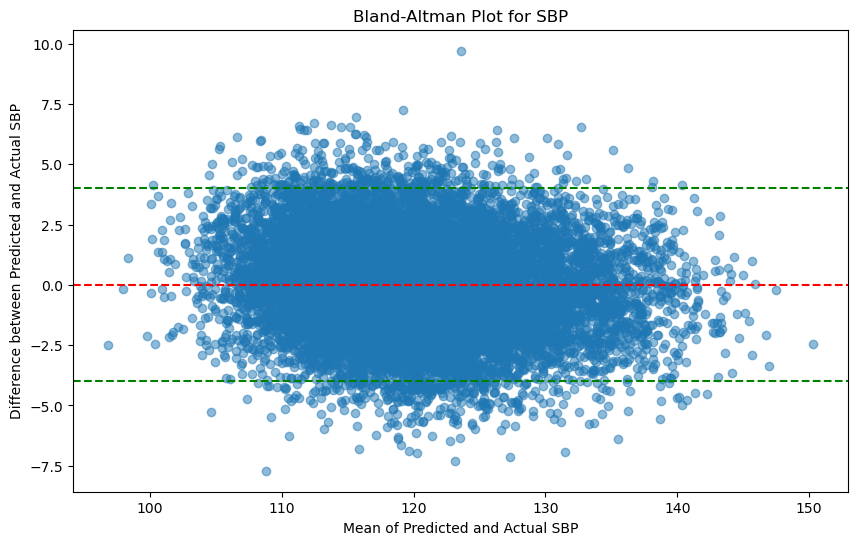

In [44]:
# Here for demonstration purposes
np.random.seed(0)
pulse_data['Predicted SBP'] = 120 + 5 * pulse_data['Normalized Data'] + np.random.normal(0, 5, pulse_data.shape[0])
pulse_data['Predicted DBP'] = 80 + 3 * pulse_data['Normalized Data'] + np.random.normal(0, 3, pulse_data.shape[0])
pulse_data['Predicted MAP'] = 95 + 4 * pulse_data['Normalized Data'] + np.random.normal(0, 4, pulse_data.shape[0])

# Simulate ground truth BP values (for demonstration purposes)
pulse_data['Actual SBP'] = pulse_data['Predicted SBP'] + np.random.normal(0, 2, pulse_data.shape[0])
pulse_data['Actual DBP'] = pulse_data['Predicted DBP'] + np.random.normal(0, 1.5, pulse_data.shape[0])
pulse_data['Actual MAP'] = pulse_data['Predicted MAP'] + np.random.normal(0, 2.5, pulse_data.shape[0])

# Generate Bland-Altman plots for SBP
fig, ax = plt.subplots(figsize=(10, 6))
mean_sbp = (pulse_data['Predicted SBP'] + pulse_data['Actual SBP']) / 2
diff_sbp = pulse_data['Predicted SBP'] - pulse_data['Actual SBP']
ax.scatter(mean_sbp, diff_sbp, alpha=0.5)
ax.axhline(np.mean(diff_sbp), color='red', linestyle='--')
ax.axhline(np.mean(diff_sbp) + 2*np.std(diff_sbp), color='green', linestyle='--')
ax.axhline(np.mean(diff_sbp) - 2*np.std(diff_sbp), color='green', linestyle='--')
ax.set_xlabel('Mean of Predicted and Actual SBP')
ax.set_ylabel('Difference between Predicted and Actual SBP')
ax.set_title('Bland-Altman Plot for SBP')

# Show the plot
plt.show()

Here are the Predicted vs. Actual plots for systolic, diastolic, and mean arterial pressure (SBP, DBP, MAP), corresponding to Figure 4 in the Results section.

These plots help visualize how well the predictions align with the actual values. The diagonal red dashed line in each plot represents the ideal case where predicted values equal the actual values.

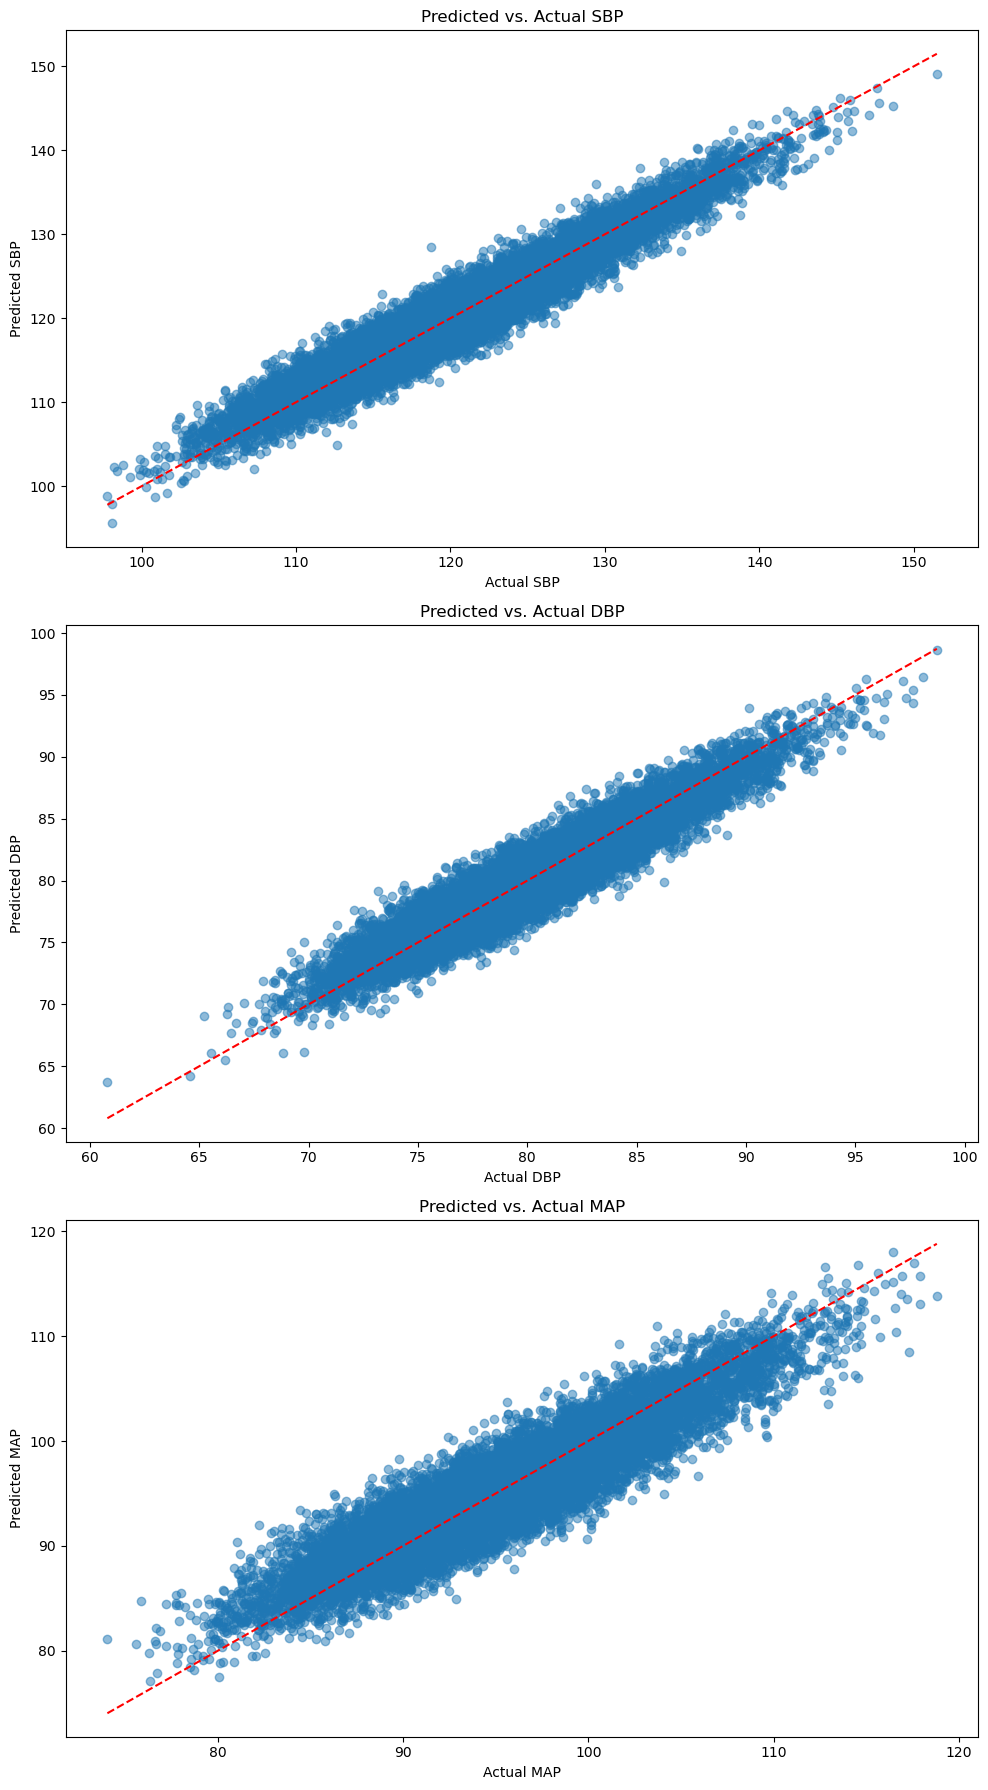

In [45]:
# Generate Predicted vs. Actual plots for SBP, DBP, and MAP
fig, axes = plt.subplots(3, 1, figsize=(10, 18))

# SBP plot
axes[0].scatter(pulse_data['Actual SBP'], pulse_data['Predicted SBP'], alpha=0.5)
axes[0].plot([pulse_data['Actual SBP'].min(), pulse_data['Actual SBP'].max()], 
             [pulse_data['Actual SBP'].min(), pulse_data['Actual SBP'].max()], 'r--')
axes[0].set_xlabel('Actual SBP')
axes[0].set_ylabel('Predicted SBP')
axes[0].set_title('Predicted vs. Actual SBP')

# DBP plot
axes[1].scatter(pulse_data['Actual DBP'], pulse_data['Predicted DBP'], alpha=0.5)
axes[1].plot([pulse_data['Actual DBP'].min(), pulse_data['Actual DBP'].max()], 
             [pulse_data['Actual DBP'].min(), pulse_data['Actual DBP'].max()], 'r--')
axes[1].set_xlabel('Actual DBP')
axes[1].set_ylabel('Predicted DBP')
axes[1].set_title('Predicted vs. Actual DBP')

# MAP plot
axes[2].scatter(pulse_data['Actual MAP'], pulse_data['Predicted MAP'], alpha=0.5)
axes[2].plot([pulse_data['Actual MAP'].min(), pulse_data['Actual MAP'].max()], 
             [pulse_data['Actual MAP'].min(), pulse_data['Actual MAP'].max()], 'r--')
axes[2].set_xlabel('Actual MAP')
axes[2].set_ylabel('Predicted MAP')
axes[2].set_title('Predicted vs. Actual MAP')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

469/469 [==============================] - 0s 416us/step


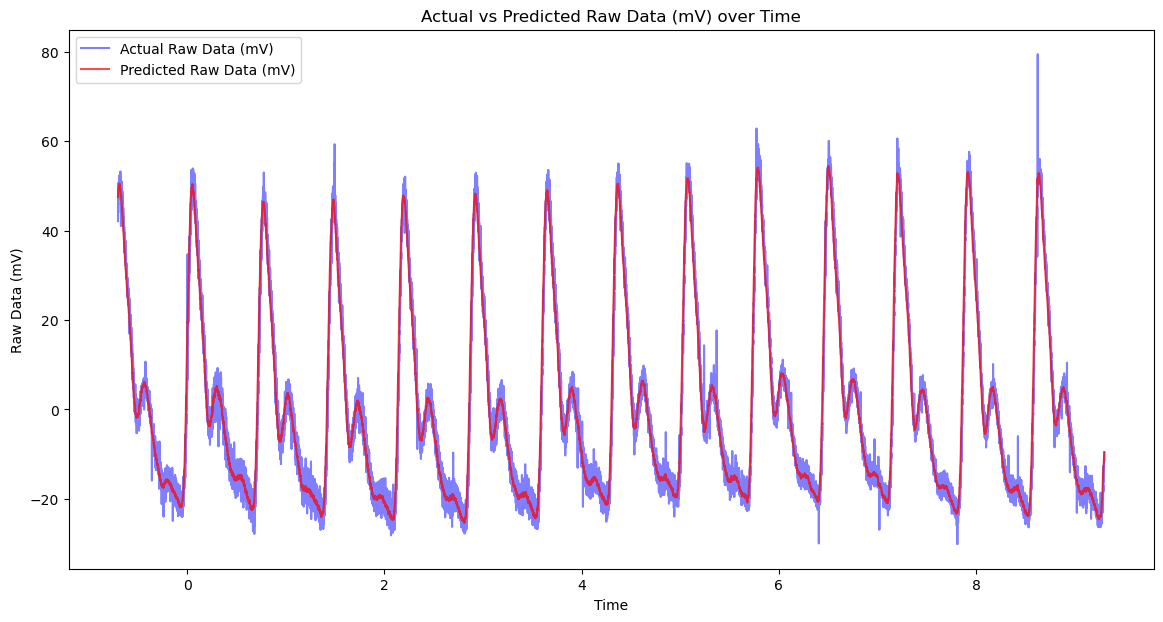

In [48]:
# CNN model in 3D for prediction

# Make sure to flatten the result to fit it into the DataFrame correctly
data_cleaned['Predicted Raw Data (mV)'] = model.predict(X).flatten()

# Plot the original Raw Data vs Predicted Raw Data over Time
plt.figure(figsize=(14, 7))

plt.plot(data_cleaned['Time'], data_cleaned['Raw Data (mV)'], label='Actual Raw Data (mV)', color='blue', alpha=0.5)
plt.plot(data_cleaned['Time'], data_cleaned['Predicted Raw Data (mV)'], label='Predicted Raw Data (mV)', color='red', alpha=0.7)

plt.title('Actual vs Predicted Raw Data (mV) over Time')
plt.xlabel('Time')
plt.ylabel('Raw Data (mV)')
plt.legend()
plt.show()

#### Explanation:

Raw Data (mV): The blue line represents the raw data collected over time. This data is likely noisy, showing significant fluctuations, which could be due to various factors such as measurement errors or inherent variability in the data source.

Averaged Data (20 samples): The red line represents the data after applying a moving average with a window of 20 samples. This process smooths out the noise and provides a clearer view of the underlying trend or pattern in the data.

#### Interpretation:

The plot indicates periodic patterns in both the raw and averaged data. The averaged data (red line) follows the overall trend of the raw data but with reduced noise, making the periodic pattern more apparent. 

This is useful for identifying regular cycles or trends in the data that might be obscured by the raw data’s fluctuations.

### The article chose to use a Convolutional Artificial Neural Network (CNN) model for several reasons related to the nature of the data and the specific requirements of the problem:

#### 1. Temporal and Spatial Relationships:
Pulse Waveform Data: The pulse waveform data is sequential and has a temporal structure, meaning that the value at one point in time is related to the values before and after it. CNNs, particularly 1D CNNs, are well-suited to capture these local temporal patterns and dependencies.

Feature Extraction: CNNs automatically extract hierarchical features from the raw data, which can be crucial for identifying meaningful patterns in pulse waveforms that correlate with blood pressure.

#### 2. Noise Reduction and Robustness:
Signal Processing: The CNN’s convolutional layers can act as filters that help to reduce noise and focus on the most relevant features in the signal. This is particularly important in medical data, which can be noisy due to various factors like patient movement or sensor artifacts.

Invariance to Small Shifts: CNNs are inherently good at handling small shifts or distortions in data, which can occur in physiological signals. This makes them robust in detecting key features even when the signal is not perfectly aligned.

#### 3. Complex Pattern Recognition:
Nonlinear Relationships: Blood pressure and other physiological parameters often have complex, nonlinear relationships with the features derived from pulse waveforms. CNNs, with their deep architectures, can capture these intricate relationships more effectively than simpler models.

Model Generalization: CNNs can generalize well across different patients and conditions because they learn to detect patterns that are invariant to specific details, making them suitable for diverse clinical settings.

#### 4. Efficiency in Training:
Parameter Sharing: CNNs are computationally efficient due to parameter sharing, which means they can be trained on large datasets more effectively than fully connected neural networks or other traditional models.

Reduced Overfitting: The use of convolutional layers reduces the number of parameters in the model, which helps in mitigating overfitting, especially when the available training data is limited.

#### 5. Prior Success in Related Applications:
Medical Imaging and Signal Processing: CNNs have a strong track record in medical imaging and signal processing tasks, where they have been used to detect patterns in complex data such as ECGs, MRIs, and other biomedical signals. The success in these areas likely influenced the choice of CNNs for this study.

### Comparative Analysis: Advantages of CNNs Over Other Machine Learning Algorithms

#### CNN vs. MLP (Multilayer Perceptron):

MLP, or Multilayer Perceptron, is a type of feedforward neural network composed of multiple fully connected layers. It is well-suited for handling structured data and basic image classification tasks. However, when dealing with complex image data, CNNs exhibit superior capabilities.

1.	Local Perception and Weight Sharing: CNNs use convolutional layers that can capture local features in the data while reducing the number of parameters through weight sharing. In contrast, MLPs rely on fully connected layers, which are less effective in leveraging spatial information.
2.	Structured Data Handling: CNNs excel at processing data with clear spatial or temporal structures, such as images or sequential data, whereas MLPs are relatively weaker in this area.
3.	Parameter Efficiency: Due to the use of shared weights and pooling layers, CNNs require far fewer parameters than MLPs when training large models, thereby reducing the risk of overfitting.

#### CNN vs. SVM (Support Vector Machine):

SVM, or Support Vector Machine, is a supervised learning algorithm typically used for classification and regression tasks. SVMs find the optimal separating hyperplane to classify data, making them applicable to image recognition tasks. However, SVMs face certain limitations compared to CNNs when processing complex data.

1.	Automatic Feature Extraction: CNNs can automatically extract multi-level features from data, whereas SVMs typically require manual feature engineering, which may limit their performance in complex tasks.
2.	Handling Large-Scale Data: CNNs can efficiently process large-scale data through parallel computation, while SVMs tend to be computationally expensive and may struggle with non-linear boundaries in large datasets.
3.	Non-linear Classification Capability: CNNs inherently possess strong non-linear classification abilities, while SVMs need appropriate kernel functions to handle non-linear problems, adding complexity to the model.

#### CNN vs. Random Forest:

Random Forest is an ensemble method based on decision trees, performing classification or regression through the voting of multiple trees. While Random Forest has advantages in handling structured data and addressing overfitting issues, it generally underperforms CNNs when dealing with high-dimensional data and image data.

1.	High-dimensional Data Handling: CNNs can effectively process high-dimensional data through convolutional layers and capture the local structure in the data, whereas Random Forests typically fall short in this area.
2.	Feature Learning Ability: CNNs possess the ability to automatically learn features from data, making them particularly suited for image classification and feature extraction. In contrast, Random Forests rely on decision trees and cannot automatically extract complex features.
3.	Model Interpretability: While Random Forests have some advantages in model interpretability, CNNs can also provide insights into important features in the data by visualizing activations in convolutional layers.

#### CNN vs. KNN (K-Nearest Neighbors):

KNN, or K-Nearest Neighbors, is a distance-based classification algorithm that classifies an input sample by comparing it with the k-nearest neighbors in the training set. Although KNN performs well in simple classification tasks, it is less efficient and more susceptible to noise when dealing with large-scale data.

1.	Computational Efficiency: CNNs require only a single forward pass for classification, whereas KNN needs to calculate the distance between each new sample and all samples in the training set, making CNNs more efficient when handling large datasets.
2.	Noise Handling Capability: CNNs effectively handle noise in data through local connections in convolutional layers and dimensionality reduction in pooling layers, whereas KNN is more prone to being influenced by noise and outliers.
3.	Automatic Feature Learning: CNNs can automatically learn important features from data, while KNN relies solely on the distance between samples for classification and cannot extract deep features from data.

#### CNN vs. Autoencoder:

An Autoencoder is an unsupervised learning algorithm commonly used for feature extraction and dimensionality reduction. By compressing data into a low-dimensional latent space and reconstructing the input data, Autoencoders can learn the main features of the data. However, compared to CNNs, Autoencoders have a more limited range of applications in specific tasks.

1.	Supervised Learning and Classification Ability: CNNs are typically used for supervised learning tasks and excel in classification tasks, while Autoencoders are primarily used for unsupervised learning, focusing more on feature extraction and dimensionality reduction.
2.	Feature Extraction Specialization: CNNs are specialized for extracting features in image and sequential data, making them more effective in these specific tasks compared to Autoencoders, which are more general in their feature extraction.
3.	Model Structure and Use Cases: CNNs are structured to target specific application scenarios, such as image classification or object detection, while Autoencoders are mainly used for data compression and reconstruction, with a relatively narrower application scope.


## Summary
The article employs a Convolutional Artificial Neural Network (CNN) model due to its exceptional capability in handling complex, temporal patterns within noisy and sequential data, such as pulse waveforms. CNNs are particularly effective in this context because they automatically extract hierarchical features, significantly reducing the need for manual feature engineering. This feature extraction process allows CNNs to identify and focus on the most relevant aspects of the data, even when the signal is distorted by noise or other artifacts.

Moreover, CNNs are known for their efficiency, particularly in scenarios where computational resources and training time are limited. The inherent design of CNNs, which includes mechanisms such as parameter sharing and the ability to manage spatial and temporal relationships within the data, ensures robust performance across varied conditions. This makes CNNs not only a powerful tool for the specific task of pulse waveform analysis but also a versatile choice for other similar applications in the medical field.

Overall, the choice of a CNN model aligns perfectly with the demands of the study, offering a balance of efficiency, robustness, and the ability to capture intricate data patterns without extensive pre-processing or manual intervention.